<a href="https://colab.research.google.com/github/delte1821/ML-SERS/blob/master/ML_SERS_v1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf
from scipy import stats

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [103]:
!pip install openpyxl

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
def initialize_paths(file_path):
    figure_path = os.path.join(file_path, "Figures")
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    return figure_path

In [106]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=None)
    materials = df.iloc[0, :].astype(int)  # Ensure materials are integers
    concentrations = df.iloc[1, :].astype(float)
    data = df.iloc[2:, :].values
    return data, materials, concentrations

In [123]:
def filter_by_material(data, materials, concentrations, material_type):
    indices = materials == material_type
    filtered_data = data[:, indices]
    filtered_concentrations = concentrations[indices]

    # Add peak information by averaging data for 603-613 and 852-862
    if material_type == 1:
        peak_data = np.mean(data[603:614, indices], axis=0)  # 603-613 (inclusive) -> 603:614 (0-indexed)
    elif material_type == 2:
        peak_data = np.mean(data[852:863, indices], axis=0)  # 852-862 (inclusive) -> 852:863 (0-indexed)
    else:
        peak_data = np.zeros(indices.sum())

    # Add the peak data as a new row to the filtered data
    filtered_data_with_peaks = np.vstack((filtered_data, peak_data))

    return filtered_data_with_peaks, filtered_concentrations

In [108]:
def preprocess_data(data):
    nsamples, nx, ny = data.shape
    data_2d = data.reshape((nsamples, nx * ny))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_2d)
    data_reshaped = data_scaled.reshape(nsamples, nx, ny)
    return data_reshaped

In [109]:
def augment_data(data, labels, num_augmented_samples=20):
    augmented_data = []
    augmented_labels = []
    original_len = len(data)
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.1, sample.shape)
            augmented_sample = sample + noise

            # Additional augmentations
            scale_factor = np.random.uniform(0.9, 1.1)
            augmented_sample = augmented_sample * scale_factor

            shift_value = np.random.uniform(-0.1, 0.1, sample.shape)
            augmented_sample = augmented_sample + shift_value

            augmented_data.append(augmented_sample)
            augmented_labels.append(label)
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)
    print(f"Original data size: {original_len}, Augmented data size: {len(augmented_data)}")
    return augmented_data, augmented_labels

In [110]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, kernel_regularizer=l2(0.01))  # Output layer for concentration prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [122]:
def train_and_validate(data, materials, concentrations, material_types, display=True, figure_path=None, epochs=200, batch_size=128):
    results = {}
    fig_counter = 1
    for mat_type in material_types:
        X, y = filter_by_material(data, materials, concentrations, mat_type)

        # Check sizes before processing
        print(f"Original X shape: {X.shape}, Original y shape: {y.shape}")

        # Ensure X and y have consistent length
        assert X.shape[1] == len(y), "Inconsistent number of samples between data and labels"

        X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.2, random_state=42)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

        # Data augmentation
        X_train, y_train = augment_data(X_train, y_train)

        X_train = preprocess_data(X_train)
        X_val = preprocess_data(X_val)

        # Reshape back to 3D for CNN input
        X_train = X_train.reshape(X_train.shape[0], -1, 1)
        X_val = X_val.reshape(X_val.shape[0], -1, 1)

        model = build_cnn_model((X_train.shape[1], 1))
        print(f"Training model for material type: {mat_type}")

        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        results[mat_type] = (mse, r2, model)

        if display:
            plot_predictions(y_val, y_pred, mat_type, fig_counter, figure_path)
            plot_training_history(history, mat_type, fig_counter, figure_path)

        fig_counter += 1
    return results


In [112]:
def plot_predictions(y_true, y_pred, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title(f'Actual vs Predicted Concentrations for {material_name}')
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [113]:
def plot_training_history(history, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Epoch vs Loss for {material_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [124]:
def classify_materials(data, materials, display=True, figure_path=None, validation_size=0.2):
    # Transpose the data to match the materials length
    data = data.T

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)

    # Ensure the lengths match
    assert data_pca.shape[0] == len(materials), "Inconsistent number of samples between data and materials"

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(data_pca, materials, test_size=validation_size, random_state=42)

    # Data augmentation for classification
    X_train, y_train = augment_data(X_train, y_train)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)

    # Train RandomForest Classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train_encoded)
    y_pred = clf.predict(X_val)

    # Decode labels
    y_pred_decoded = le.inverse_transform(y_pred)

    # Convert integer labels to strings for classification_report
    target_names = [str(label) for label in le.classes_]

    # Print classification report
    print("Material Classification Report (Validation):")
    print(classification_report(y_val_encoded, y_pred, target_names=target_names))

    # Plot confusion matrix
    if display:
        plot_confusion_matrix(y_val_encoded, y_pred, target_names, figure_path)

    # Calculate and print specificity and sensitivity
    cm = confusion_matrix(y_val_encoded, y_pred)
    specificity, sensitivity = calculate_specificity_sensitivity(cm)

    # Save the sensitivity and specificity to a file
    fig_counter = 1
    results_file_path = os.path.join(figure_path, f'Sensitivity_Specificity_{fig_counter}.txt')
    while os.path.exists(results_file_path):
        fig_counter += 1
        results_file_path = os.path.join(figure_path, f'Sensitivity_Specificity_{fig_counter}.txt')
    with open(results_file_path, 'w') as f:
        for i, material in enumerate(target_names):
            f.write(f"Material: {material}\n")
            f.write(f"Specificity: {specificity[i]:.2f}\n")
            f.write(f"Sensitivity: {sensitivity[i]:.2f}\n")
            f.write("\n")

    # Also print the sensitivity and specificity to the console
    for i, material in enumerate(target_names):
        print(f"Material: {material}")
        print(f"Specificity: {specificity[i]:.2f}")
        print(f"Sensitivity: {sensitivity[i]:.2f}")
        print()


In [115]:
def calculate_specificity_sensitivity(cm):
    """
    Calculate the specificity and sensitivity for each class given a confusion matrix.

    Args:
    - cm: Confusion matrix (numpy array).

    Returns:
    - specificity: List of specificity values for each class.
    - sensitivity: List of sensitivity values for each class.
    """
    specificity = []
    sensitivity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # True Negatives
        fp = np.sum(np.delete(cm[:, i], i))  # False Positives
        fn = np.sum(np.delete(cm[i, :], i))  # False Negatives
        tp = cm[i, i]  # True Positives

        specificity.append(tn / (tn + fp))
        sensitivity.append(tp / (tp + fn))
    return specificity, sensitivity

In [116]:
def plot_confusion_matrix(y_true, y_pred, labels, figure_path, fig_counter=1):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.figure(figsize=(8, 6))
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [117]:
# Paths and instantiation
file_path = "/content/drive/My Drive/Colab Notebooks/Spectra/Low"  # Update to your actual path in Google Drive
figure_path = initialize_paths(file_path)
original_file_path = os.path.join(file_path, "Combine.xlsx")
display = True

# Load and preprocess data
data, materials, concentrations = load_data(original_file_path)
material_types = [1, 2]  # Focusing on IL6 and TNF for example

Original X shape: (1025, 124), Original y shape: (124,)
Original data size: 99, Augmented data size: 2079
Training model for material type: 1
Epoch 1/1000
65/65 [==============================] - 3s 19ms/step - loss: 621.4040 - val_loss: 1109.7057
Epoch 2/1000
65/65 [==============================] - 1s 16ms/step - loss: 488.0586 - val_loss: 833.5710
Epoch 3/1000
65/65 [==============================] - 1s 16ms/step - loss: 363.6468 - val_loss: 684.8836
Epoch 4/1000
65/65 [==============================] - 1s 16ms/step - loss: 282.7133 - val_loss: 606.9743
Epoch 5/1000
65/65 [==============================] - 1s 16ms/step - loss: 204.9181 - val_loss: 520.5384
Epoch 6/1000
65/65 [==============================] - 1s 16ms/step - loss: 160.0326 - val_loss: 482.8717
Epoch 7/1000
65/65 [==============================] - 1s 16ms/step - loss: 134.2334 - val_loss: 371.3481
Epoch 8/1000
65/65 [==============================] - 1s 15ms/step - loss: 140.8053 - val_loss: 382.5470
Epoch 9/1000
65/6

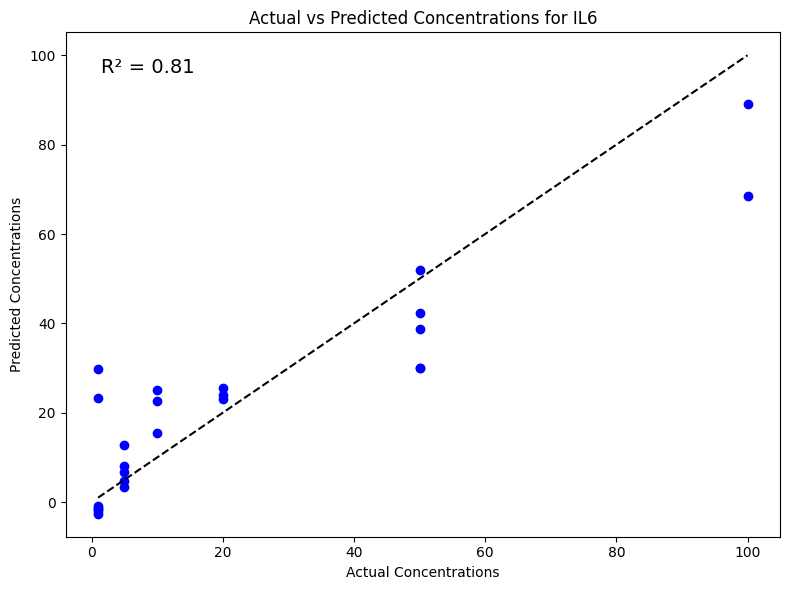

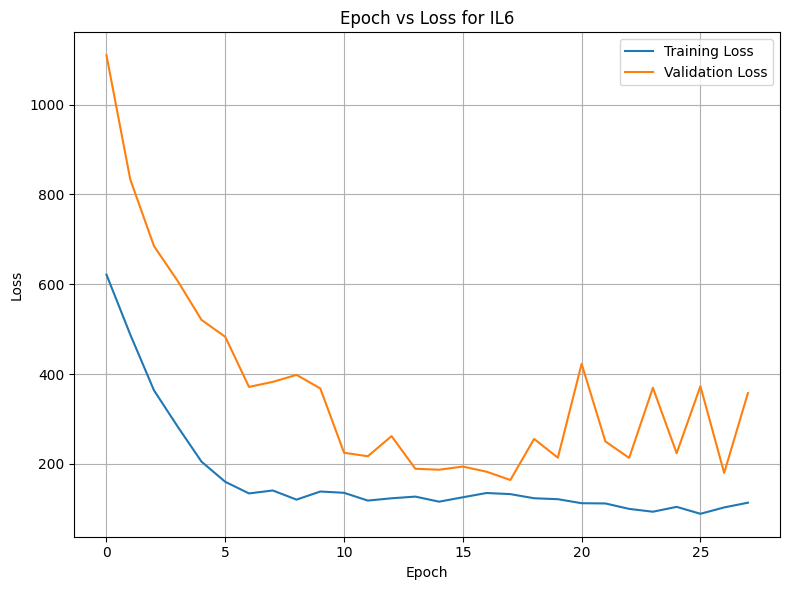

Original X shape: (1025, 81), Original y shape: (81,)
Original data size: 64, Augmented data size: 1344
Training model for material type: 2
Epoch 1/1000
42/42 [==============================] - 2s 20ms/step - loss: 2730.0408 - val_loss: 7968.9585
Epoch 2/1000
42/42 [==============================] - 1s 15ms/step - loss: 1603.3698 - val_loss: 7320.0225
Epoch 3/1000
42/42 [==============================] - 1s 15ms/step - loss: 869.8663 - val_loss: 6740.4102
Epoch 4/1000
42/42 [==============================] - 1s 15ms/step - loss: 545.9326 - val_loss: 6241.3735
Epoch 5/1000
42/42 [==============================] - 1s 15ms/step - loss: 466.8421 - val_loss: 5950.2246
Epoch 6/1000
42/42 [==============================] - 1s 15ms/step - loss: 442.3661 - val_loss: 5786.5410
Epoch 7/1000
42/42 [==============================] - 1s 15ms/step - loss: 441.3030 - val_loss: 5189.9399
Epoch 8/1000
42/42 [==============================] - 1s 15ms/step - loss: 378.6749 - val_loss: 4773.1348
Epoch 9/10

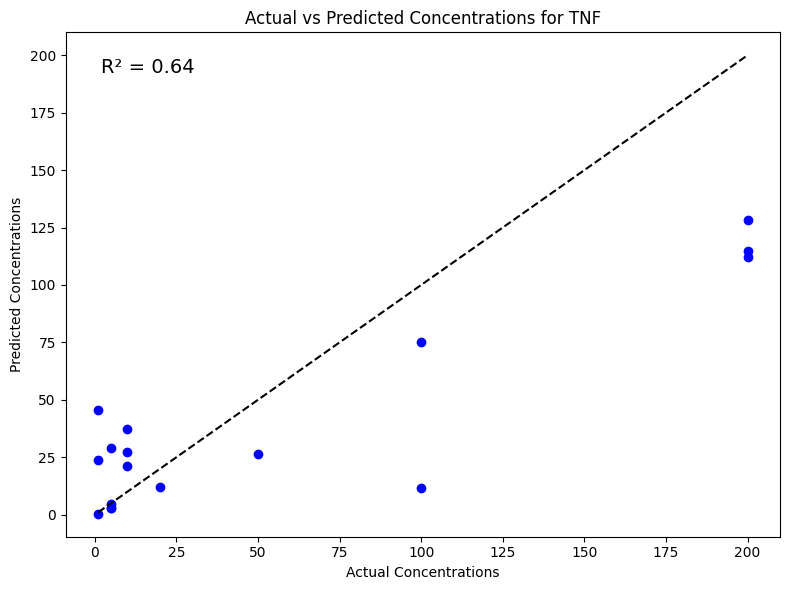

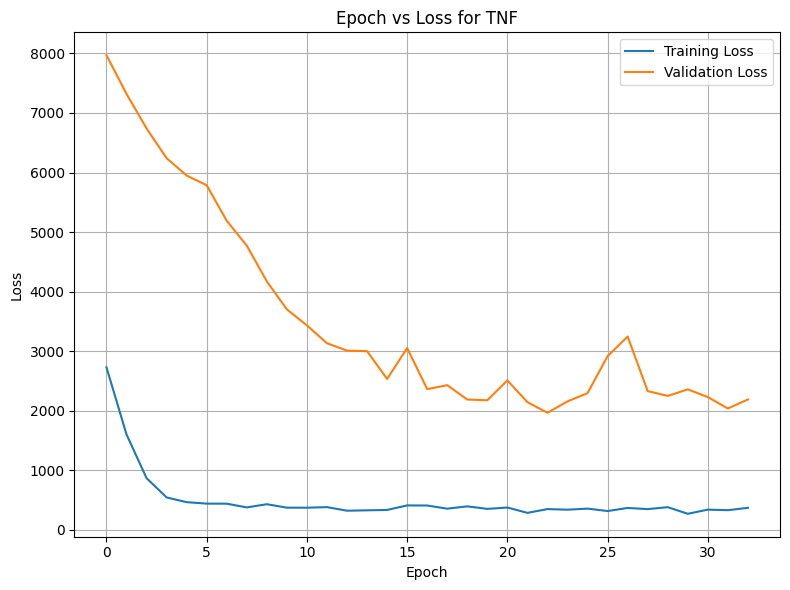

In [127]:
# Train and validate with increased epochs and batch size
results_regression = train_and_validate(data, materials, concentrations, material_types, display=display, figure_path=figure_path, epochs=1000, batch_size=32)

Original data size: 162, Augmented data size: 3402
Material Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.97      1.00      0.99        37
           2       0.86      1.00      0.92        24

    accuracy                           0.93        70
   macro avg       0.94      0.81      0.84        70
weighted avg       0.94      0.93      0.92        70



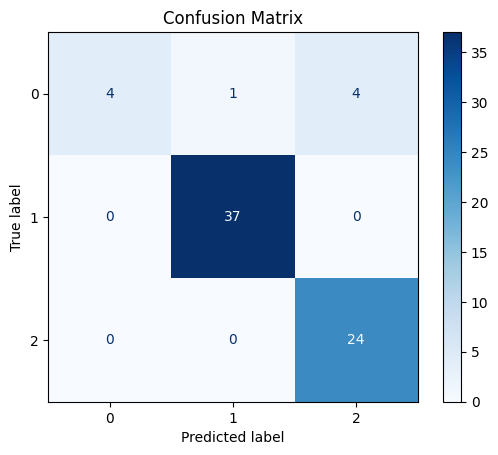

<Figure size 800x600 with 0 Axes>

Material: 0
Specificity: 1.00
Sensitivity: 0.44

Material: 1
Specificity: 0.97
Sensitivity: 1.00

Material: 2
Specificity: 0.91
Sensitivity: 1.00



In [128]:
# Classification with increased validation set
classify_materials(data, materials, display=display, figure_path=figure_path, validation_size=0.3)